In [8]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

# --- Constants ---
IMG_SIZE = 1024
SIGMA = 3
CSV_PATH = r"C:\STUDIE\4. Semester\Dataprojekt\Dataprojekt\Data\Clean Data\Overbite Data\Updated_Labels.csv"
TRAIN_IMG_DIR = r"C:\STUDIE\4. Semester\Dataprojekt\Dataprojekt\Data\Clean Data\Overbite Data\Annotated Data Pairs"
VAL_IMG_DIR = r"C:\STUDIE\4. Semester\Dataprojekt\Dataprojekt\Data\Clean Data\Overbite Data\Annotated Verication data"

# --- Heatmap Utility ---
def make_heatmap(x, y, size=IMG_SIZE, sigma=SIGMA):
    X, Y = np.meshgrid(np.arange(size), np.arange(size))
    heatmap = np.exp(-((X - x) ** 2 + (Y - y) ** 2) / (2 * sigma ** 2))
    return heatmap.astype(np.float32)

# --- Dataset ---
class HeatmapKeypointDataset(Dataset):
    def __init__(self, csv_file, img_dir, img_size=IMG_SIZE, sigma=SIGMA):
        df = pd.read_csv(csv_file)
        all_imgs = set(os.listdir(img_dir))
        self.data = df[df["Filename"].isin(all_imgs)].reset_index(drop=True)
        self.img_dir = img_dir
        self.img_size = img_size
        self.sigma = sigma
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row["Filename"])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        kp_x = row["X"] * (self.img_size / 1024)
        kp_y = row["Y"] * (self.img_size / 1024)
        heatmap = make_heatmap(kp_x, kp_y, size=self.img_size, sigma=self.sigma)
        img = torch.tensor(img / 255.0, dtype=torch.float32).permute(2,0,1)
        heatmap = torch.tensor(heatmap, dtype=torch.float32).unsqueeze(0)
        return img, heatmap, row["Filename"], kp_x, kp_y

# --- Model (Simple U-Net) ---
class UNetSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=32):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base, 3, 1, 1), nn.ReLU(),
                                  nn.Conv2d(base, base, 3, 1, 1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(nn.Conv2d(base, base*2, 3, 1, 1), nn.ReLU(),
                                  nn.Conv2d(base*2, base*2, 3, 1, 1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)
        self.middle = nn.Sequential(nn.Conv2d(base*2, base*4, 3, 1, 1), nn.ReLU())
        self.up1 = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.dec1 = nn.Sequential(nn.Conv2d(base*4, base*2, 3, 1, 1), nn.ReLU())
        self.up2 = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.dec2 = nn.Sequential(nn.Conv2d(base*2, base, 3, 1, 1), nn.ReLU())
        self.final = nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        m = self.middle(self.pool2(e2))
        d1 = self.up1(m)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        out = self.final(d2)
        return out  # shape: (B, 1, H, W)

# --- Dataloaders ---
train_set = HeatmapKeypointDataset(CSV_PATH, TRAIN_IMG_DIR, img_size=IMG_SIZE, sigma=SIGMA)
val_set = HeatmapKeypointDataset(CSV_PATH, VAL_IMG_DIR, img_size=IMG_SIZE, sigma=SIGMA)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=8)

# --- Training (w. AMP, scheduler, validation) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetSmall(in_ch=3, out_ch=1, base=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

for epoch in range(100):
    model.train()
    epoch_loss = 0
    for img, heatmap, *_ in train_loader:
        img = img.to(device)
        heatmap = heatmap.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(img)
            loss = criterion(out, heatmap)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item() * img.size(0)
    epoch_loss /= len(train_loader.dataset)

    # --- Validation loss ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for img, heatmap, *_ in val_loader:
            img = img.to(device)
            heatmap = heatmap.to(device)
            with torch.cuda.amp.autocast():
                out = model(img)
                loss = criterion(out, heatmap)
            val_loss += loss.item() * img.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}: train_loss={epoch_loss:.5f}, val_loss={val_loss:.5f}")
    scheduler.step(val_loss)


C:\Users\tueme\AppData\Local\Temp\ipykernel_22556\1619817175.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


RuntimeError: DataLoader worker (pid(s) 13380, 2612, 20596, 17248, 32116, 11780, 25292, 22112) exited unexpectedly

In [4]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Constants ---
IMG_SIZE = 224
DATA_ROOT = r"C:\STUDIE\4. Semester\Dataprojekt\Dataprojekt\Data\Clean Data\Overbite Data"
CSV_PATH = os.path.join(DATA_ROOT, "Updated_Labels.csv")
TEST_IMG_DIR = os.path.join(DATA_ROOT, "Annotated Test data")

# --- Dataset class ---
class KeypointDataset(Dataset):
    def __init__(self, csv_file, img_dir, img_size=IMG_SIZE, transform=None):
        df = pd.read_csv(csv_file)
        all_imgs = set(os.listdir(img_dir))
        self.data = df[df["Filename"].isin(all_imgs)].reset_index(drop=True)
        self.img_dir = img_dir
        self.img_size = img_size
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row["Filename"])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        kp_x = row["X"] / 1024   # Normalize to [0,1]
        kp_y = row["Y"] / 1024
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img / 255.0, dtype=torch.float32).permute(2,0,1)
        target = torch.tensor([kp_x, kp_y], dtype=torch.float32)
        return img, target, row["Filename"]

# --- Reload test set with batch_size=1 for visualization ---
test_set = KeypointDataset(CSV_PATH, TEST_IMG_DIR, IMG_SIZE)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)


In [5]:
model.eval()
for i, (img, target, fname) in enumerate(test_loader):
    pred = model(img).detach().numpy()
    # Convert normalized prediction to original pixel coordinates
    x_pred = pred[0, 0] * 1024
    y_pred = pred[0, 1] * 1024
    x_gt = target[0, 0].item() * 1024
    y_gt = target[0, 1].item() * 1024

    # Get the filename string, even if wrapped in tuple/list
    fname_str = fname if isinstance(fname, str) else fname[0]
    orig_img_path = os.path.join(TEST_IMG_DIR, fname_str)
    orig_img = cv2.imread(orig_img_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    plt.imshow(orig_img)
    plt.scatter([x_pred], [y_pred], color='r', s=40, label='Predicted')
    plt.scatter([x_gt], [y_gt], color='g', s=40, label='GT')
    plt.legend()
    plt.title("Red=Pred, Green=GT")
    plt.show()
    if i > 5: break  # Show 6 examples


IndexError: index 1 is out of bounds for axis 1 with size 1

Mean pixel error: 13.19
Median pixel error: 11.37


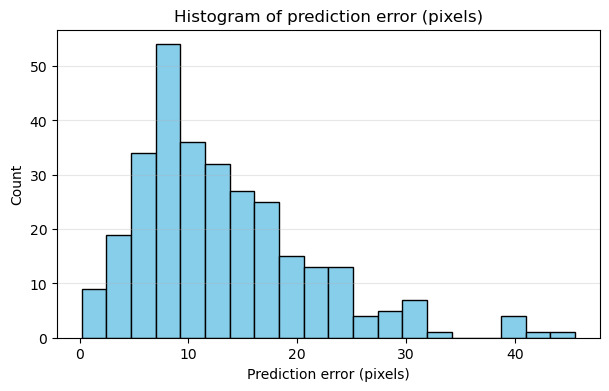

In [9]:
import numpy as np
import matplotlib.pyplot as plt

distances = []

model.eval()
for img, target, fname in test_loader:
    pred = model(img).detach().numpy()
    # Predicted coordinates in pixels
    x_pred = pred[0, 0] * 1024
    y_pred = pred[0, 1] * 1024
    # Ground truth in pixels
    x_gt = target[0, 0].item() * 1024
    y_gt = target[0, 1].item() * 1024
    # Euclidean distance
    dist = np.sqrt((x_pred - x_gt) ** 2 + (y_pred - y_gt) ** 2)
    distances.append(dist)

distances = np.array(distances)
print(f"Mean pixel error: {distances.mean():.2f}")
print(f"Median pixel error: {np.median(distances):.2f}")

# Plot histogram
plt.figure(figsize=(7, 4))
plt.hist(distances, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Prediction error (pixels)")
plt.ylabel("Count")
plt.title("Histogram of prediction error (pixels)")
plt.grid(True, axis='y', alpha=0.3)
plt.show()


Mean error: 1.06 mm


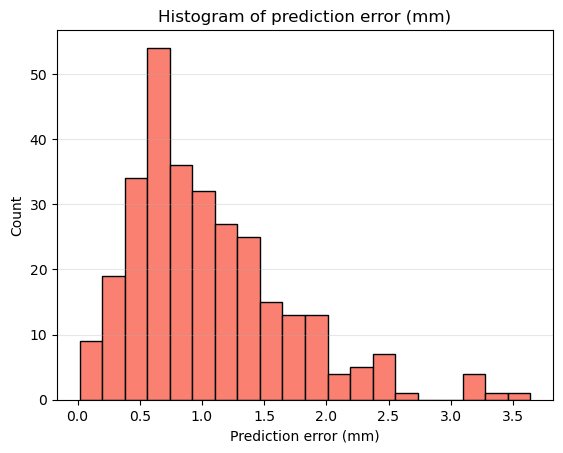

In [10]:
distances_mm = distances * 0.08
print(f"Mean error: {distances_mm.mean():.2f} mm")
plt.hist(distances_mm, bins=20, color="salmon", edgecolor="black")
plt.xlabel("Prediction error (mm)")
plt.ylabel("Count")
plt.title("Histogram of prediction error (mm)")
plt.grid(True, axis='y', alpha=0.3)
plt.show()
